XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.
Test generalization by training and testing on different stations

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190728-112854'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
landcover, landcover_legend = load_data.load_landcover_reduced()

../src/load_data.py:242: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [4]:
station_cell_mapping = load_data.get_station_cell_mapping()

In [7]:
for station in station_data_dict.keys():
    for i in range(len(landcover_legend)):
        value = 0.0
        for row_col in station_cell_mapping[station_cell_mapping['station']=='station'][['row','col']].values:
            value += landcover[i, row_col[1]-1, row_col[0]-1]
        station_data_dict[station]['{}'.format(landcover_legend[i])] = value / station_cell_mapping[station_cell_mapping['station']==station].shape[0]

In [8]:
test_station_fraction = 0.25
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
train_stations, test_stations

(array(['02GA010', '02GA018', '02GA038', '02GA047', '02GB007', '02GC002',
        '02GC007', '02GC010', '02GC018', '02GE007', '02GG002', '02GG003',
        '02GG006', '02GG009', '02GG013', '04159492', '04159900',
        '04161820', '04165500', '04166100', '04174500', '04176500',
        '04198000', '04199000', '04199500', '04200500', '04207200',
        '04208504', '04209000', '04212100', '04213000', '04213500',
        '04214500', '04215000', '04215500'], dtype='<U8'),
 array(['04166500', '04164000', '04177000', '02GB001', '02GC026',
        '04196800', '04193500', '02GD004', '04160600', '04197100',
        '04195820'], dtype='<U8'))

In [9]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

m = xgb.XGBRegressor(n_estimators=1000, n_jobs=44, random_state=123, colsample_bylevel=.8357617548460161,
                    colsample_bytree=0.7279736118769715, gamma=0.6959743989532903, learning_rate=0.1456725523229726, max_depth=3, min_child_weight=5,
                     reg_alpha=45.191905388077004, reg_lambda=8.021568667278883, subsample=0.9708847409794326)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=True)

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Shapes: train (33309, 8746), val (3701, 8746), test (8030, 8746)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:27.3524	validation_1-rmse:24.9511
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:26.2615	validation_1-rmse:24.2303
[2]	validation_0-rmse:25.3339	validation_1-rmse:23.5533
[3]	validation_0-rmse:24.5116	validation_1-rmse:23.0118
[4]	validation_0-rmse:23.8867	validation_1-rmse:22.5781
[5]	validation_0-rmse:23.3343	validation_1-rmse:22.3166
[6]	validation_0-rmse:22.823	validation_1-rmse:22.0254
[7]	validation_0-rmse:22.4061	validation_1-rmse:21.8498
[8]	validation_0-rmse:22.0186	validation_1-rmse:21.5607
[9]	validation_0-rmse:21.7432	validation_1-rmse:21.3915
[10]	validation_0-rmse:21.4794	validation_1-rmse:21.34
[11]	validation_0-rmse:21.1872	validation_1-rmse:21.1291
[12]	validation_0-rmse:20.9486	validation_1-rmse:21.0358
[13]	validation_0-rmse:20.7308	validation_1-rmse:20.9368
[14]	validation_0-rmse:20.5668	validation_1-rmse:20.907

02GA010 	NSE: 0.3326647226276712 	MSE: 318.16780807784824 (clipped to 0)
02GA018 	NSE: 0.31456956068937847 	MSE: 172.14803484577163 (clipped to 0)
02GA038 	NSE: 0.2886475336290517 	MSE: 117.04483714928091 (clipped to 0)
02GA047 	NSE: 0.09136116447009102 	MSE: 71.22822072845452 (clipped to 0)
02GB001 	NSE: -0.5462301486194958 	MSE: 11611.995444449001 (clipped to 0)
02GB007 	NSE: 0.29296176569247845 	MSE: 22.11050993562692 (clipped to 0)
02GC002 	NSE: 0.5195288574013286 	MSE: 61.741999871505016 (clipped to 0)
02GC007 	NSE: 0.3075425907215229 	MSE: 20.857748158319776 (clipped to 0)
02GC010 	NSE: 0.3768760052065042 	MSE: 37.04467151522355 (clipped to 0)
02GC018 	NSE: 0.5257203586489483 	MSE: 32.121443231561166 (clipped to 0)
02GC026 	NSE: 0.04695436889259563 	MSE: 153.28095291118677 (clipped to 0)
02GD004 	NSE: 0.007945865297843135 	MSE: 54.625549648745434 (clipped to 0)
02GE007 	NSE: 0.2375929807156959 	MSE: 27.58011850788896 (clipped to 0)
02GG002 	NSE: 0.5927095626933652 	MSE: 98.231458

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04164000 	NSE: 0.30261290952055997 	MSE: 122.2012971249725 (clipped to 0)
04165500 	NSE: 0.5513320478869483 	MSE: 200.85020997224595 (clipped to 0)
04166100 	NSE: -0.008852530821121363 	MSE: 7.398226018434551 (clipped to 0)
04166500 	NSE: 0.09714194534833165 	MSE: 31.20664975846793 (clipped to 0)
04174500 	NSE: 0.2646035969362647 	MSE: 69.5495534076976 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04176500 	NSE: 0.1298896731097232 	MSE: 594.3499296987665 (clipped to 0)
04177000 	NSE: -0.025640822656410878 	MSE: 27.640845617852715 (clipped to 0)
04193500 	NSE: -0.15151958618178174 	MSE: 81528.4494982598 (clipped to 0)
04195820 	NSE: -0.24285073385708045 	MSE: 1458.851150984662 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04196800 	NSE: -0.5609415536404223 	MSE: 467.1093981880275 (clipped to 0)
04197100 	NSE: -4.771706135041342 	MSE: 591.9716329525925 (clipped to 0)
04198000 	NSE: 0.5568176036032091 	MSE: 3274.036279273069 (clipped to 0)
04199000 	NSE: 0.5198203219659646 	MSE: 491.0333232477047 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04199500 	NSE: 0.40540395368275817 	MSE: 240.60217346718645 (clipped to 0)
04200500 	NSE: 0.5617795799331806 	MSE: 438.52934614083387 (clipped to 0)
04207200 	NSE: 0.21184053548362913 	MSE: 18.447890013168536 (clipped to 0)
04208504 	NSE: 0.5202576985590524 	MSE: 468.4821049355489 (clipped to 0)
04209000 	NSE: 0.41302253621239704 	MSE: 183.5220353090197 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04212100 	NSE: 0.5076667261926912 	MSE: 722.9052726394884 (clipped to 0)
04213000 	NSE: 0.47372485504688977 	MSE: 94.45019839215499 (clipped to 0)
04213500 	NSE: 0.5707911388770529 	MSE: 439.6887866780017 (clipped to 0)
04214500 	NSE: 0.4555376176994975 	MSE: 65.62790957353704 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215000 	NSE: 0.32549890225534306 	MSE: 64.78772768842485 (clipped to 0)
04215500 	NSE: 0.46215179722608557 	MSE: 97.12727012350553 (clipped to 0)
Train Median NSE (clipped to 0) 0.41302253621239704 / Min -0.008852530821121363 / Max 0.6333377691645322
Train Median MSE (clipped to 0) 94.45019839215499 / Min 7.398226018434551 / Max 3274.036279273069
Test Median NSE (clipped to 0) -0.025640822656410878 / Min -4.771706135041342 / Max 0.30261290952055997
Test Median MSE (clipped to 0) 153.28095291118677 / Min 27.640845617852715 / Max 81528.4494982598


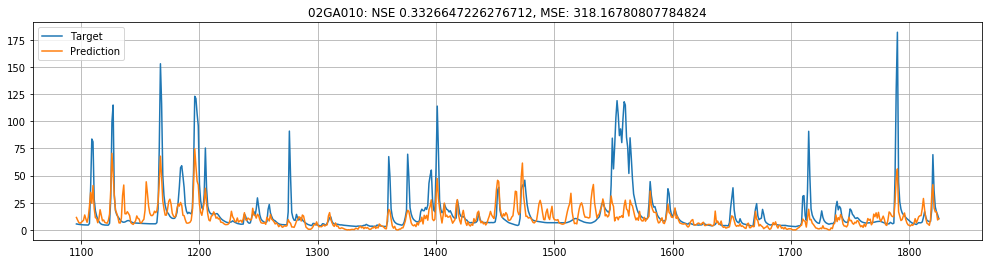

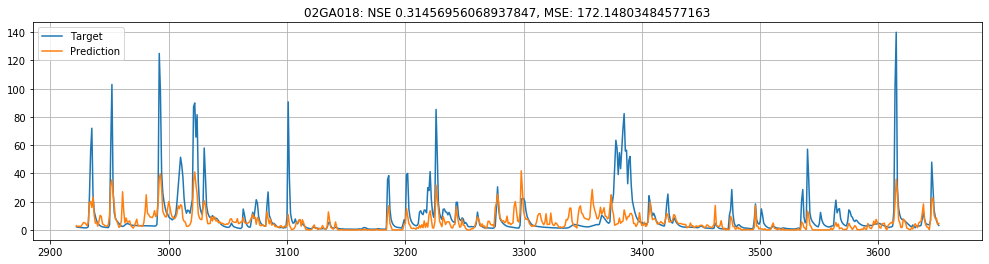

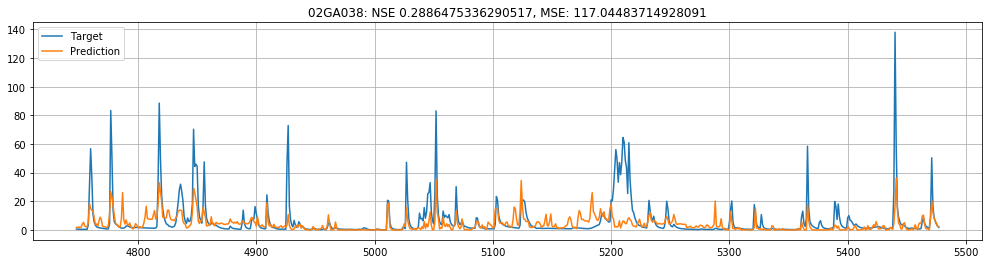

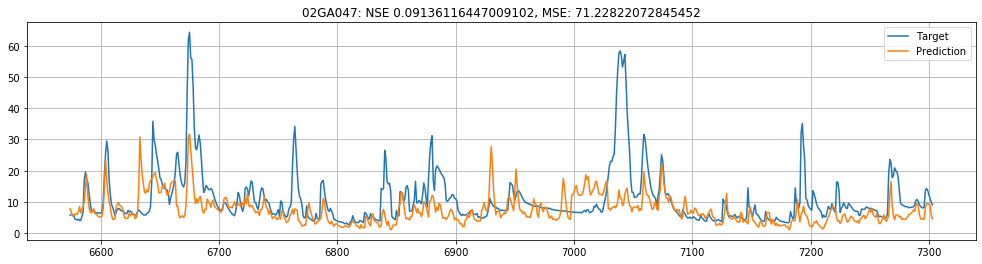

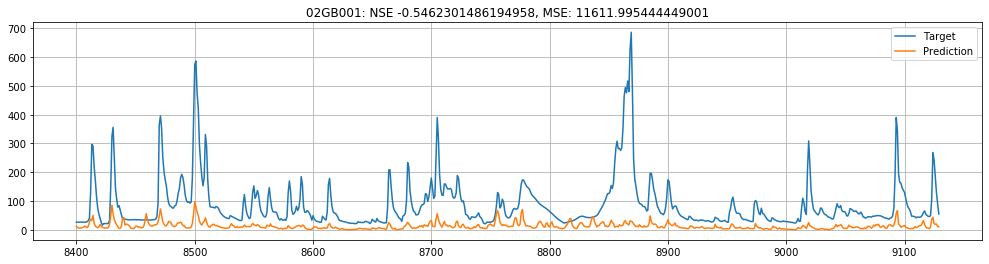

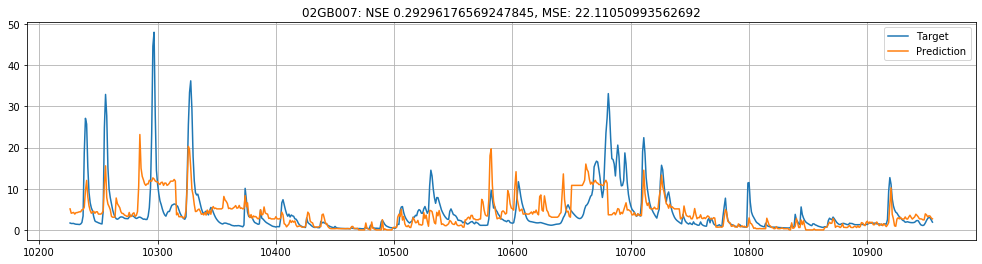

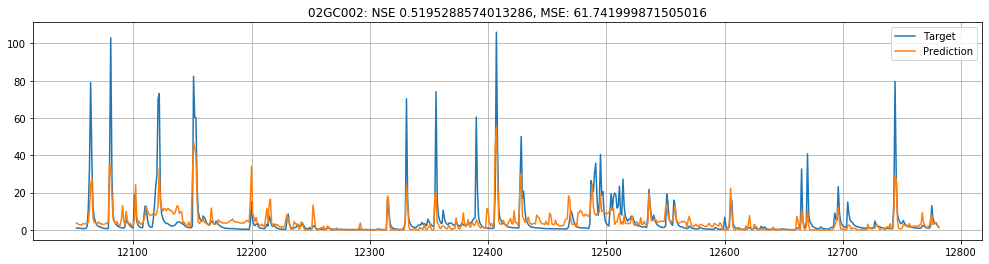

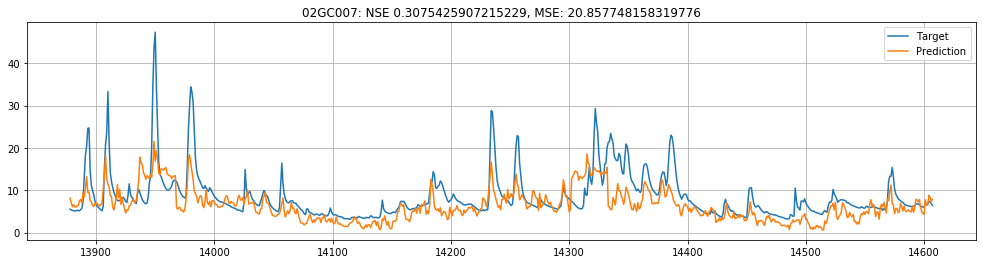

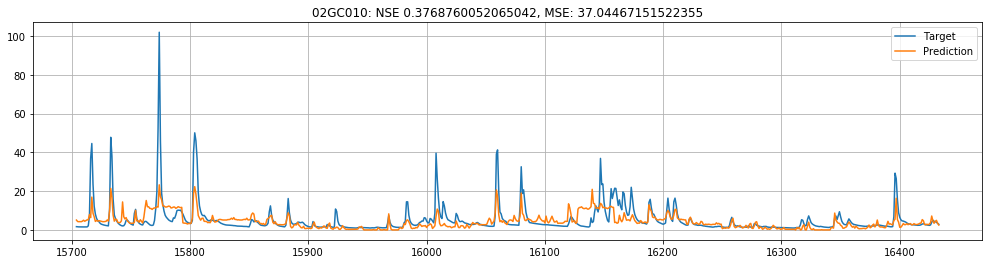

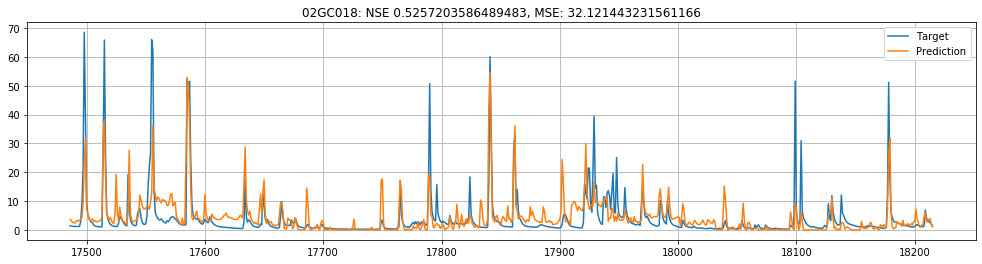

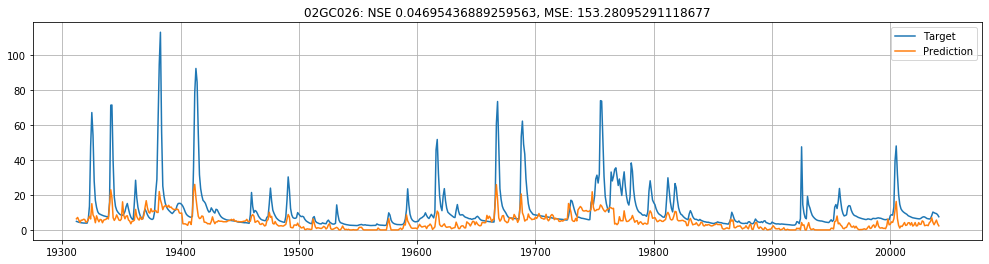

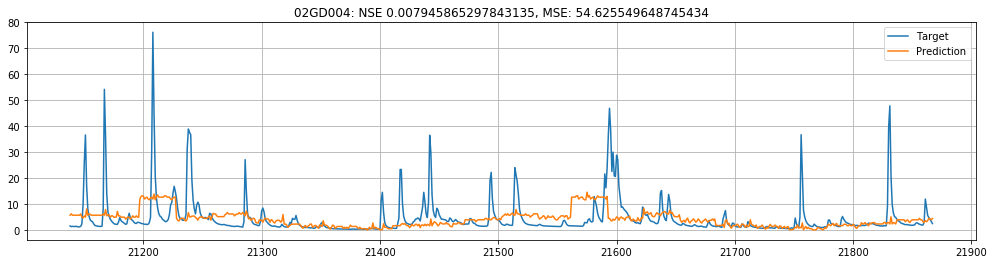

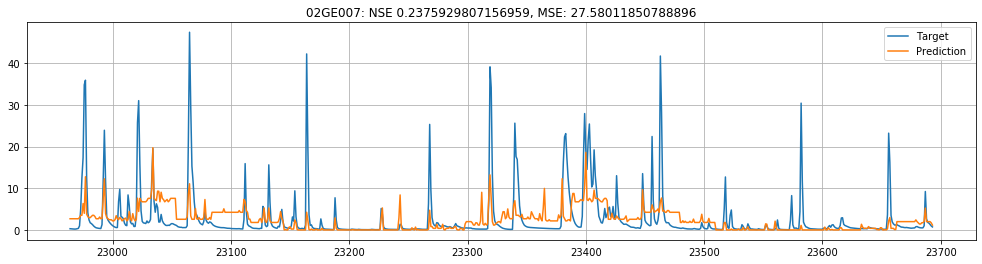

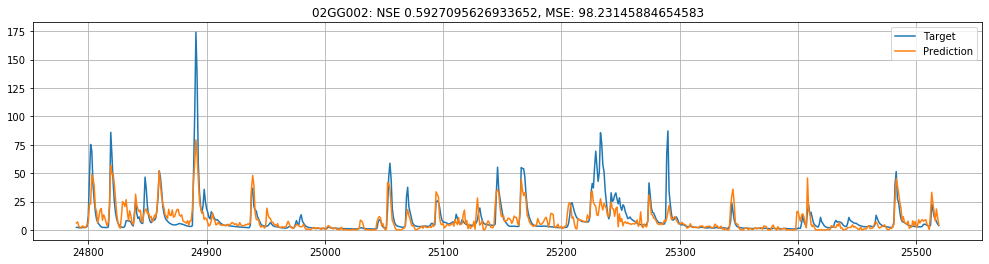

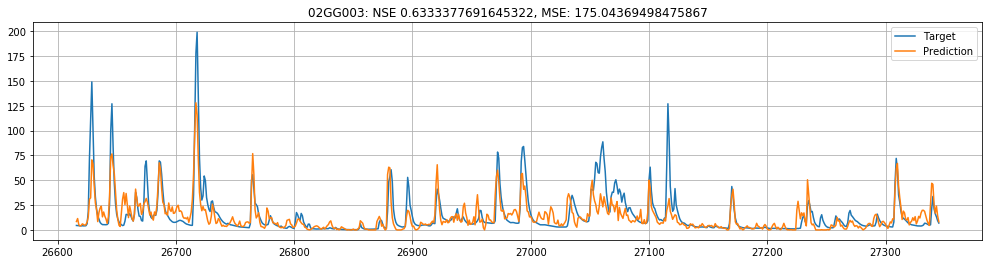

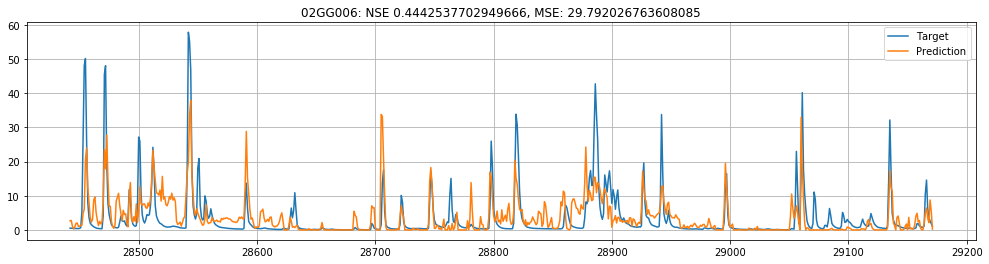

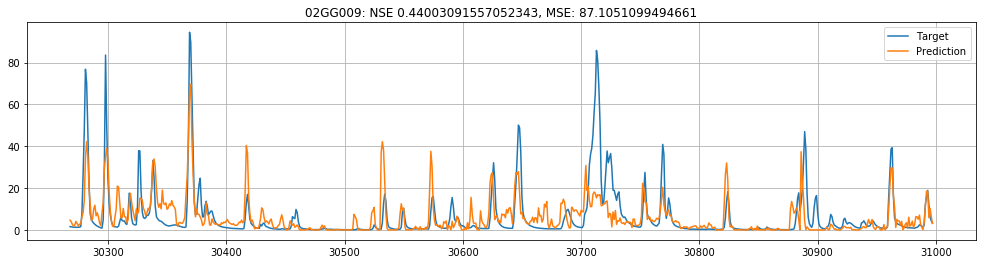

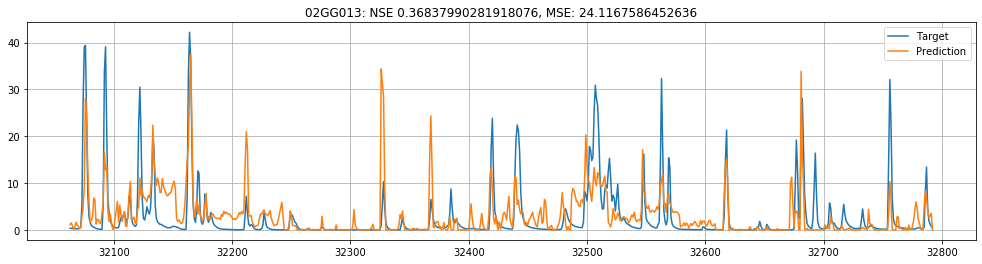

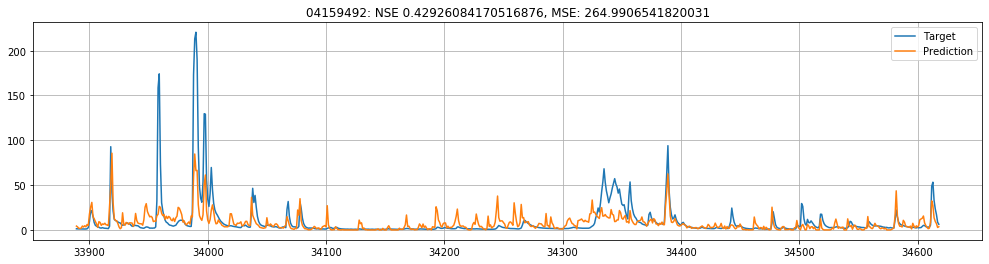

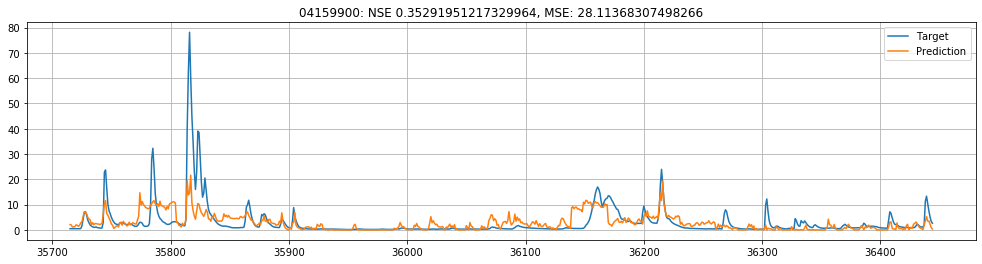

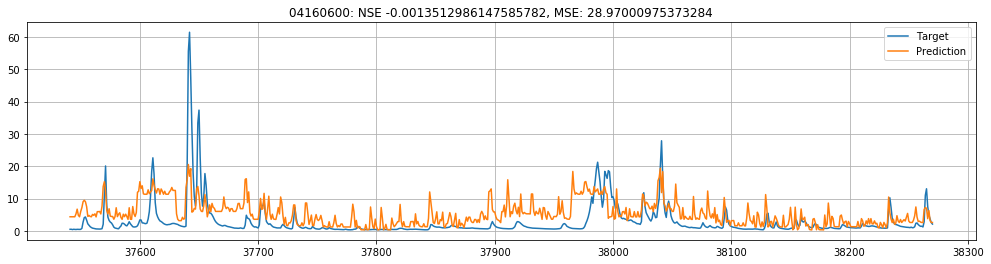

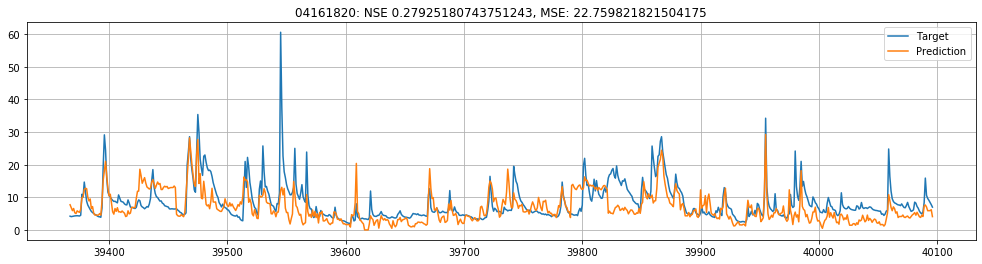

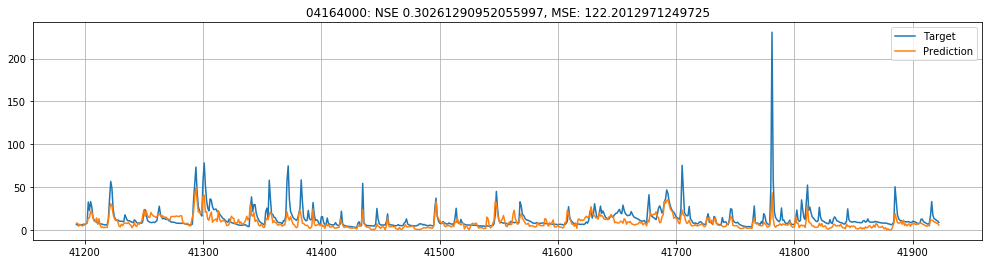

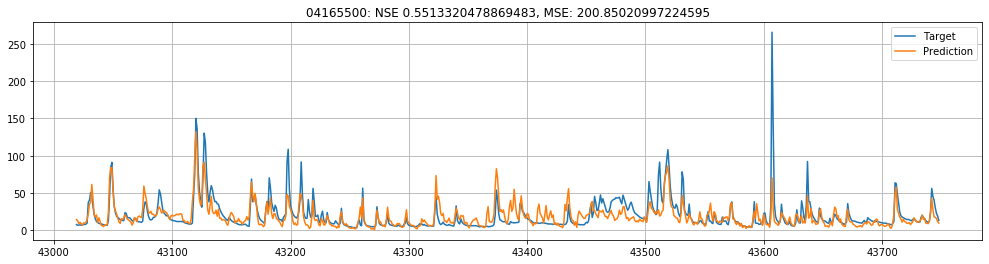

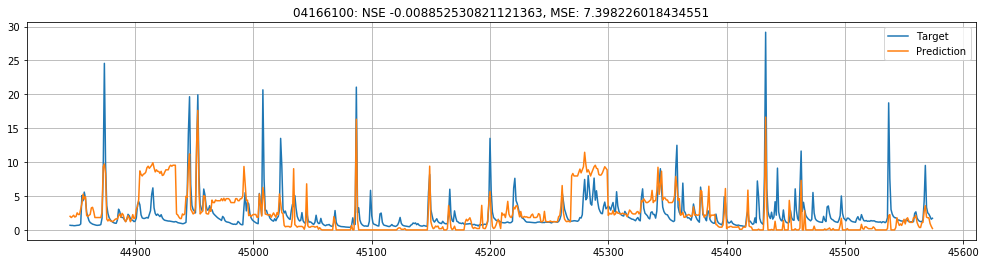

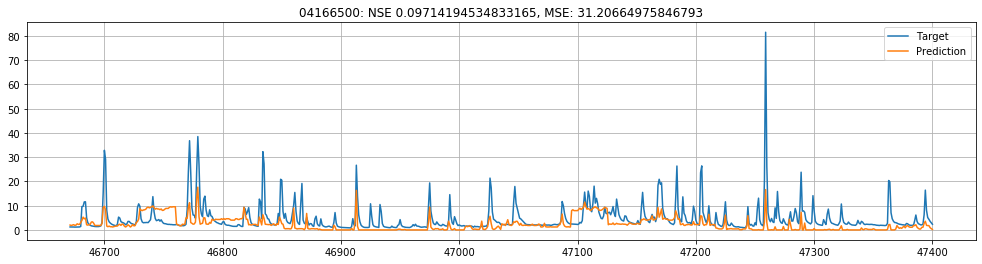

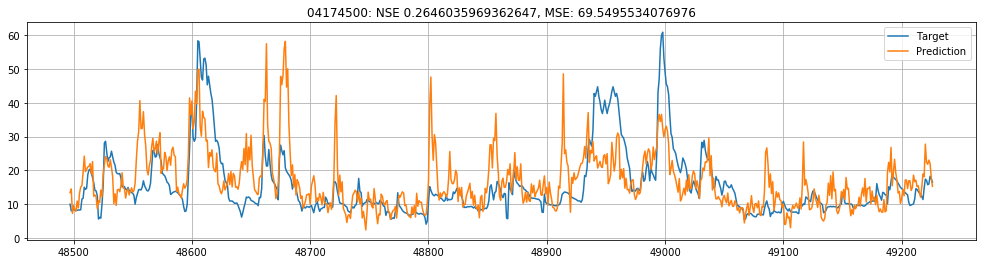

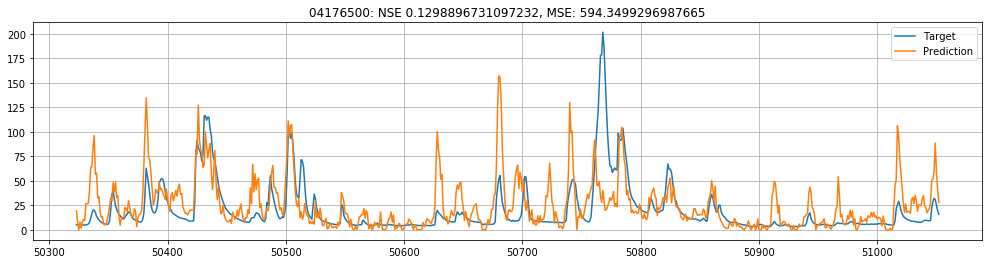

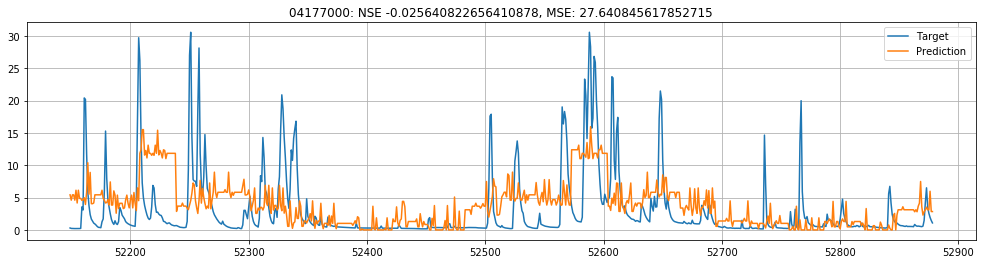

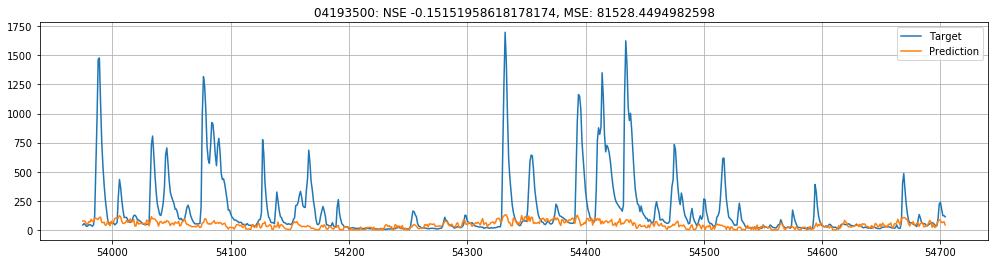

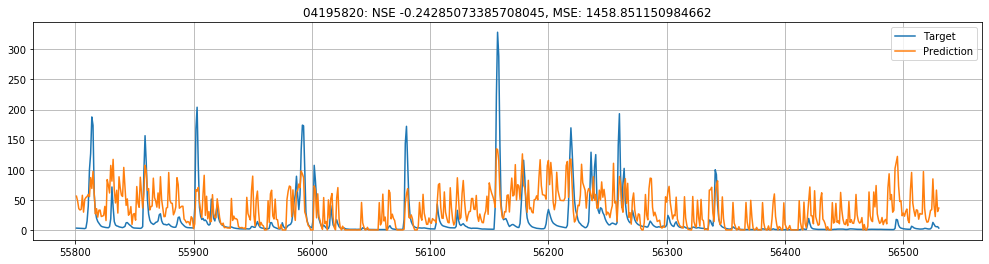

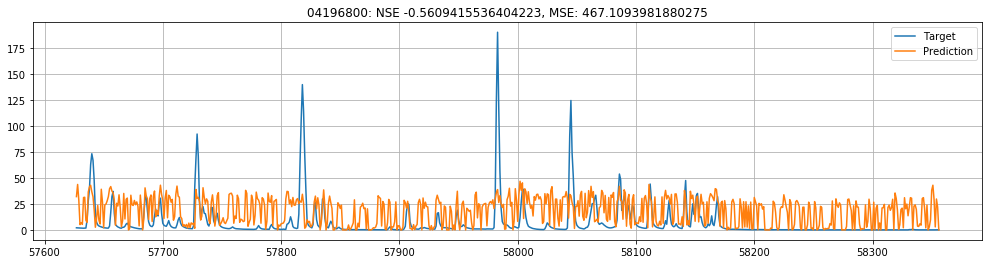

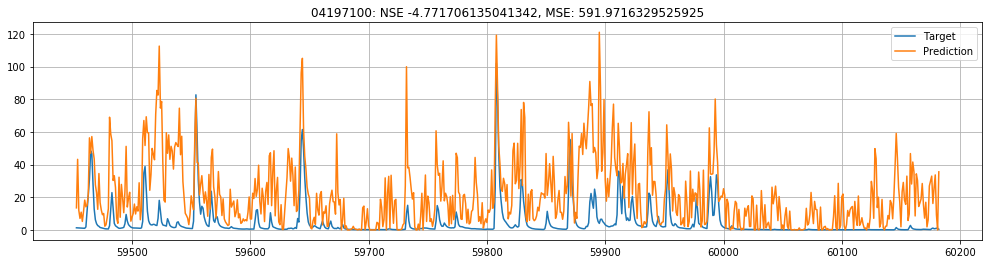

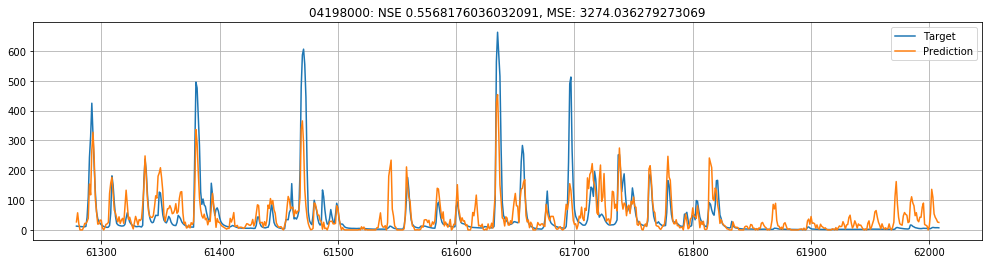

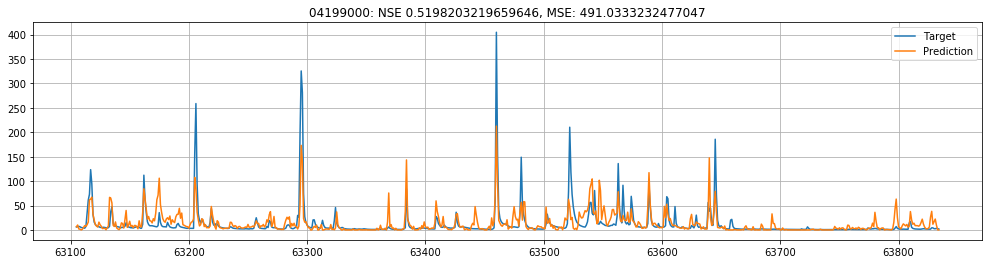

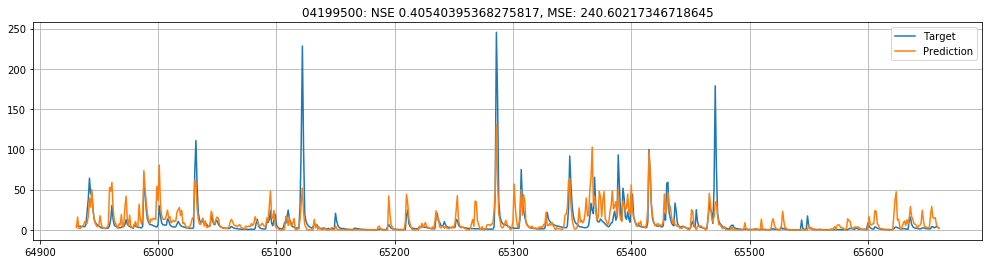

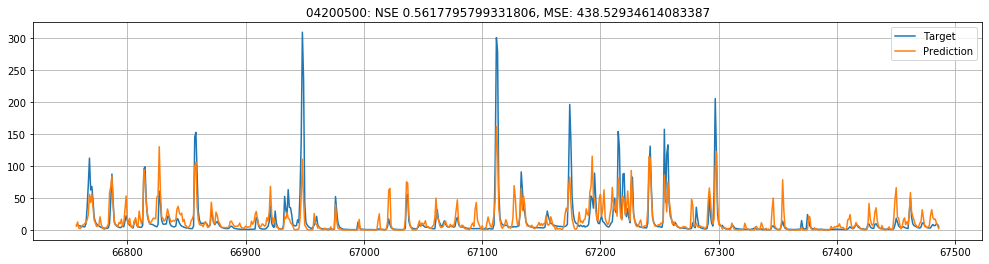

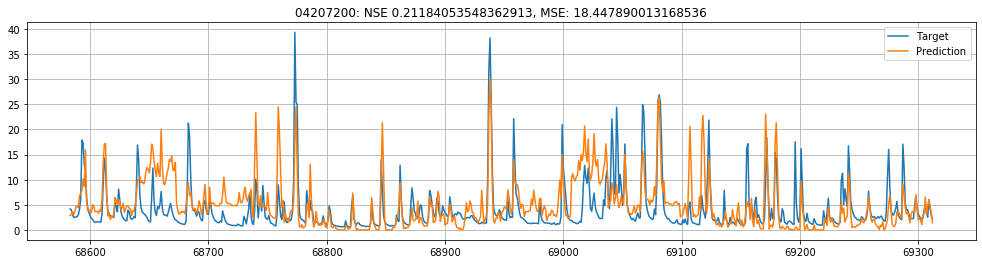

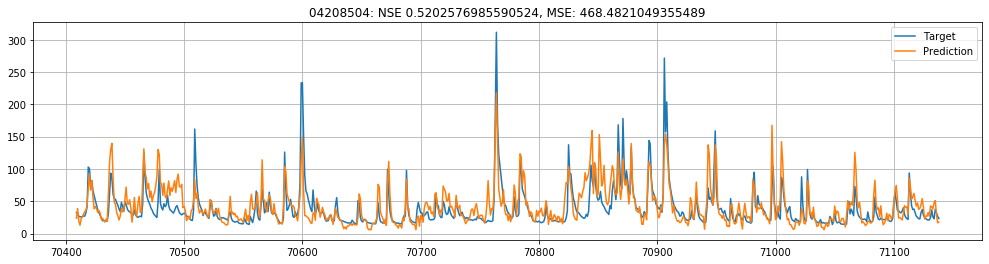

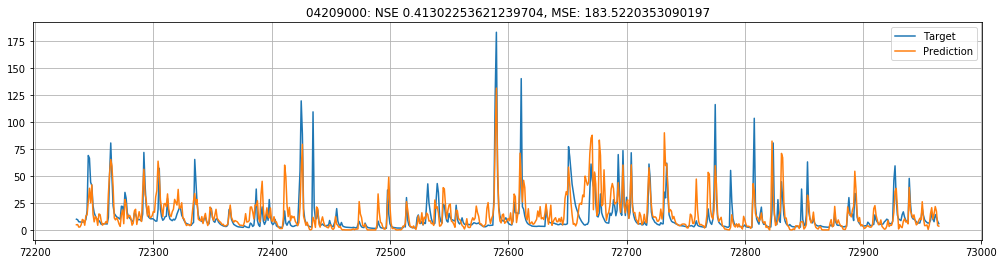

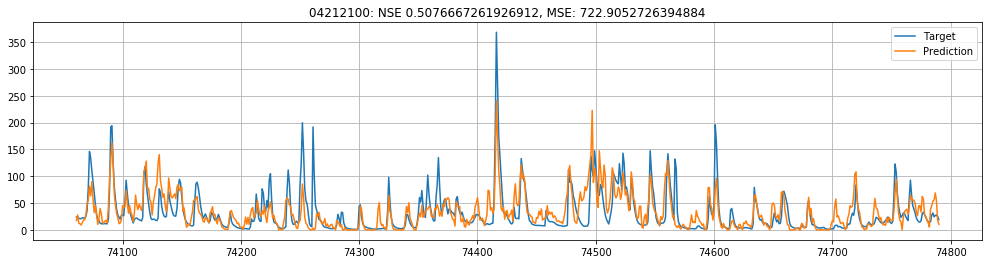

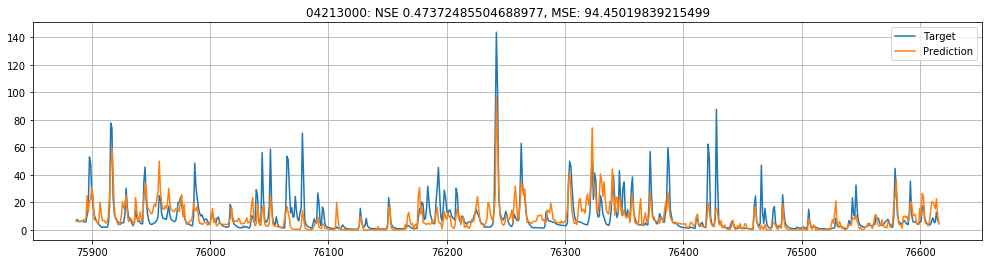

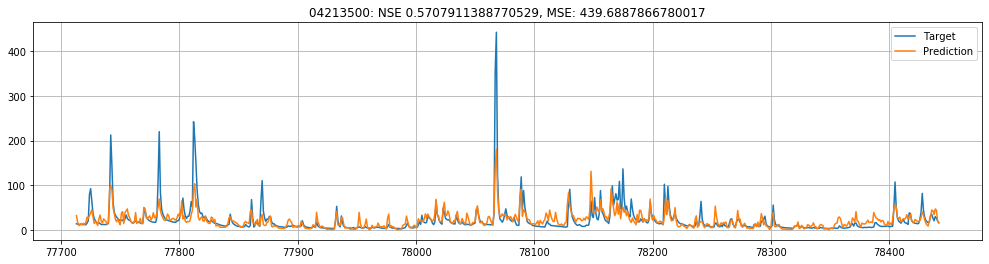

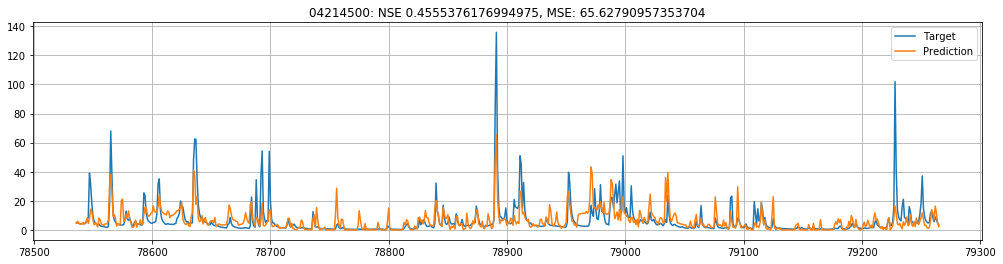

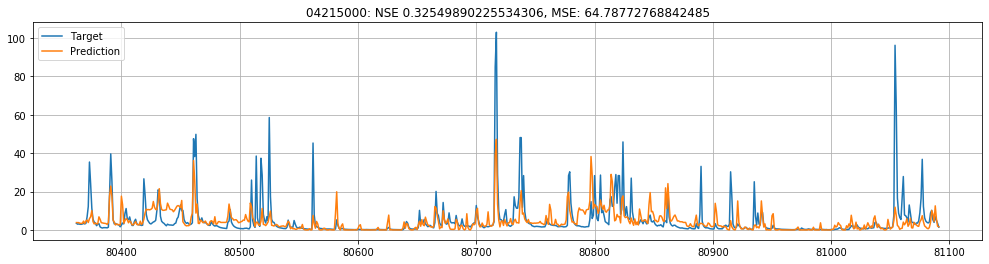

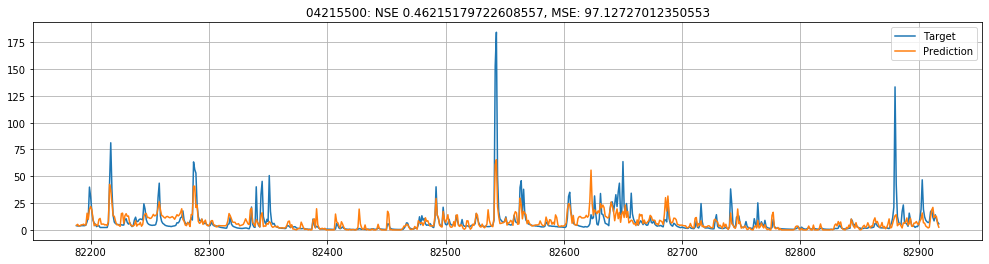

In [10]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [11]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_20190728-112854.pkl'

In [12]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', m, 'all', time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_all_20190728-112854.pkl


In [13]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190728-114311'